### create baseline.csv (no need to rerun, will take some time)¶

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import os

from IPython.display import display
import ipywidgets as widgets

all=pd.read_csv('./data/instance_header_info.csv')
all['fname'] = all['fname'].str.replace(r'\.zip$', '', regex=True)
all = all.rename(columns={'fname':'name'})
names = all['name'].unique()

if not os.path.isfile('./baseline.csv'):

    progress = widgets.IntProgress(value=0, min=0, max=len(names)-1)
    label = widgets.Label('')
    display(widgets.HBox((progress, label)))
    
    with open('./baseline.csv', 'w') as fp_out:
        fp_out.write('name,nodes,edges,density,limit,has_leafs,int_only\n')
        for idx, name in enumerate(names):
            progress.value = idx
            label.value = name
    
            int_only = True
            G = nx.Graph()
            with open(f'./data/instances/{name}.txt') as fp:
                for line in fp.readlines():
                    if line.startswith('#'):
                        continue
                    data = line.strip().split(' ')
                    if len(data) == 3:
                        if '.' in data[2]:
                            int_only = False
                        G.add_edge(int(data[0]), int(data[1]), weight=float(data[2]))
    
            nodes = G.number_of_nodes()
            edges = G.number_of_edges()
            density = 2*edges/(nodes*(nodes-1)) 
             
            has_leafs = False
            for node in list(G.nodes):
                if len(list(G.neighbors(node))) == 1:
                    has_leafs = True
                    break
            
            filename = f'./BASELINE/{name}-X-5.csv'
            if os.path.isfile(filename):
                data = pd.read_csv(filename)
                limit = max(0.001, round(np.mean(data['runtime']), 3))
                fp_out.write(f'{name},{nodes},{edges},{density},{limit:.3f},{has_leafs},{int_only}\n')
                fp_out.flush()
    
    progress.value = progress.max
    label.value = 'ready'

else:

    print('\nskipped')


skipped


# create script to run heuristics

In [2]:
def get_size(node:int)-> str:
    if 20 <= nodes < 1024:
        return 'x-small'
    elif 1024 <= nodes < 2048:
        return 'small'
    elif 2048 <= nodes < 4096:
        return 'medium'
    elif 4096 <= nodes < 8192:
        return 'large'
    elif 8192 <= nodes:
        return 'x-large'
    return None

sizes = ['x-small', 'small', 'medium', 'large', 'x-large']

def get_density(density_value:float)->str:
    if density_value < 0.1:
        return 'sparse'
    elif 0.1 <= density_value < 0.5:
        return 'medium'
    elif 0.5 <= density_value:
        return 'dense'   
    return None

densities = ['sparse', 'medium', 'dense']

In [3]:
import tabulate

heuristic_map = {
'sparse':{'x-small':'BURER2002', 'small':'BURER2002', 'medium':'BURER2002', 'large':'BURER2002', 'x-large':'MERZ1999GLS'},
'medium':{'x-small':'PALUBECKIS2004bMST2', 'small':'PALUBECKIS2004bMST2', 'medium':'PALUBECKIS2004bMST2', 'large':'PALUBECKIS2004bMST2', 'x-large':''},
'dense':{'x-small':'PALUBECKIS2004bMST2', 'small':'PALUBECKIS2004bMST2', 'medium':'PALUBECKIS2004bMST2', 'large':'PALUBECKIS2004bMST2', 'x-large':''}
}

table = [[density] + list(heuristic_map[density].values()) for density in densities]
print(tabulate.tabulate(table, ['density\size'] + sizes, tablefmt='psql'))


+----------------+---------------------+---------------------+---------------------+---------------------+-------------+
| density\size   | x-small             | small               | medium              | large               | x-large     |
|----------------+---------------------+---------------------+---------------------+---------------------+-------------|
| sparse         | BURER2002           | BURER2002           | BURER2002           | BURER2002           | MERZ1999GLS |
| medium         | PALUBECKIS2004bMST2 | PALUBECKIS2004bMST2 | PALUBECKIS2004bMST2 | PALUBECKIS2004bMST2 |             |
| dense          | PALUBECKIS2004bMST2 | PALUBECKIS2004bMST2 | PALUBECKIS2004bMST2 | PALUBECKIS2004bMST2 |             |
+----------------+---------------------+---------------------+---------------------+---------------------+-------------+


In [4]:
import os
import math
import tabulate
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
from IPython.display import display
import ipywidgets as widgets
from datetime import timedelta

import glob

df=pd.read_csv('baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

df = df[df['limit']>=0.25] # skip cases with limit below 250 msec

counter = {density:{size:0 for size in sizes} for density in densities}

for name, limit, nodes, density_value in zip(df['name'], df['limit'], df['nodes'], df['density']):

    size = get_size(nodes)
    density = get_density(density_value)

    if size is not None and density is not None:
        counter[density][size] += 1
    else:
        print(name, limit, nodes, density_value)


table = [[density] + list(counter[density].values()) + [sum(list(counter[density].values()))] for density in densities]
table.append(['TOTAL'] + [sum([counter[density][size] for density in densities]) for size in sizes] + [sum(     sum(list(counter[density].values())) for density in densities      )])
print(tabulate.tabulate(table, ['density\size'] + sizes + ['sum'], tablefmt='psql'))



heuristics = [heuristic for heuristic in sorted(set(sum([list(heuristic_map[density].values()) for density in densities], []))) if heuristic != '']
print('heuristics', heuristics)
                   

for tgt_heuristic in heuristics:

    for tgt_density in densities:
        for tgt_size in sizes:
    
            lines = []
            total_limit = 0
            
            for name, limit, nodes, density_value in zip(df['name'], df['limit'], df['nodes'], df['density']):
            
                size = None
                if 20 <= nodes < 1024:
                    size = 'x-small'
                elif 1024 <= nodes < 2048:
                    size = 'small'
                elif 2048 <= nodes < 4096:
                    size = 'medium'
                elif 4096 <= nodes < 8192:
                    size = 'large'
                elif 8192 <= nodes:
                    size = 'x-large'
            
                density = None
                if density_value < 0.1:
                    density = 'sparse'
                elif 0.1 <= density_value < 0.5:
                    density = 'medium'
                elif 0.5 <= density_value:
                    density = 'dense'
    
                if tgt_density == density:
                    if tgt_size == size:
                        if tgt_heuristic == heuristic_map[density][size]:
                        
                            csv_filename = f'./{tgt_heuristic}/{name}-{limit:.3f}-5.csv'
                            if not os.path.isfile(csv_filename):
                                lines.append(f'python -u mqlib.py --case {name:13s} --heuristic {tgt_heuristic:19s} --limit {limit:8.3f}\n')
                                total_limit += limit
                                print(csv_filename)
                                print(glob.glob( f'./{tgt_heuristic}/{name}*'))
            
            cmd_filename = f'cmd-{tgt_heuristic}-{tgt_density}-{tgt_size}.sh'

            if os.path.isfile(cmd_filename):
                 os.remove(cmd_filename)
                
            if len(lines) > 0:
                print(tgt_heuristic, tgt_density, tgt_size, timedelta(seconds=5*total_limit), 'until', datetime.now()  + timedelta(seconds=5*total_limit))
                with open(cmd_filename, 'w') as fp:
                    fp.write(''.join(lines))   
            else:
                print(tgt_heuristic, tgt_density, tgt_size, 'ready')
    
    print()

print('\nready')
    

+----------------+-----------+---------+----------+---------+-----------+-------+
| density\size   |   x-small |   small |   medium |   large |   x-large |   sum |
|----------------+-----------+---------+----------+---------+-----------+-------|
| sparse         |       525 |     179 |      279 |     171 |        81 |  1235 |
| medium         |       367 |      41 |       78 |     119 |         0 |   605 |
| dense          |       182 |      12 |       50 |      41 |         0 |   285 |
| TOTAL          |      1074 |     232 |      407 |     331 |        81 |  2125 |
+----------------+-----------+---------+----------+---------+-----------+-------+
heuristics ['BURER2002', 'MERZ1999GLS', 'PALUBECKIS2004bMST2']
BURER2002 sparse x-small ready
BURER2002 sparse small ready
BURER2002 sparse medium ready
BURER2002 sparse large ready
BURER2002 sparse x-large ready
BURER2002 medium x-small ready
BURER2002 medium small ready
BURER2002 medium medium ready
BURER2002 medium large ready
BURER2002 me

### DAv3 time_limit_sec based on limit

In [5]:
def calc_time_limit_sec(limit:float, offset:int=2)-> int:
    return  max(1, min(int(math.floor(limit)), int(math.floor(limit*1.10 - offset))))

### Compare time_limit_secs for different offsets 

In [6]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from decimal import *
getcontext().prec = 50

df = pd.read_csv('./baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

df = df[df['limit']>=0.25] # skip cases with limit below 250 msec

for base_offset in range(6):
    table = []
    for offset in range(6):
        counters = {i:0 for i in range(-5, +5+1, +1)}
        for name, limit in zip(df['name'], df['limit']):
            t1 = calc_time_limit_sec(limit, base_offset)
            t2 = calc_time_limit_sec(limit, offset)
            counters[t2-t1] += 1
        table.append([offset] + [counter if counter>0 else None for delta, counter in counters.items()] )
    print(tabulate.tabulate(table, [f'offset vs. {base_offset}'] + list(counters.keys()),  tablefmt='psql'))
    print()


+----------------+------+------+------+------+------+------+-----+-----+-----+-----+-----+
|   offset vs. 0 |   -5 |   -4 |   -3 |   -2 |   -1 |    0 | 1   | 2   | 3   | 4   | 5   |
|----------------+------+------+------+------+------+------+-----+-----+-----+-----+-----|
|              0 |      |      |      |      |      | 2125 |     |     |     |     |     |
|              1 |      |      |      |      |  344 | 1781 |     |     |     |     |     |
|              2 |      |      |      |  222 |  447 | 1456 |     |     |     |     |     |
|              3 |      |      |  131 |  366 |  294 | 1334 |     |     |     |     |     |
|              4 |      |   74 |  293 |  252 |  233 | 1273 |     |     |     |     |     |
|              5 |   35 |  239 |  215 |  191 |  219 | 1226 |     |     |     |     |     |
+----------------+------+------+------+------+------+------+-----+-----+-----+-----+-----+

+----------------+------+------+------+------+------+------+-----+-----+-----+-----+-----

### create script to run DAv*

In [7]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from decimal import *
getcontext().prec = 50

# --- DAv2 -----------------------------------------------------------------------

df = pd.read_csv('./baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df[df['nodes'] <= 8192+1]
df = df.sort_values(by='limit')

# --------------------------------------------------------------------------------

missing = []
lines = []
for name, limit, nodes in zip(df['name'], df['limit'], df['nodes']):
    csv_filename = f'./DAv2/{name}-{limit:.3f}-5.csv'
    log_filename = f'./DAv2/{name}-{limit:.3f}-5.log'
    if not os.path.isfile(csv_filename):        
        lines.append(f"echo {name} {limit:.3f}\n")
        lines.append(f"./maxcutV2 -c {name} -l {limit:.3f} -e 5 -o {csv_filename} -v > {log_filename} 2>&1\n")
        missing.append(limit)

cmd_filename = 'cmd-DAv2.sh'

if os.path.isfile(cmd_filename):
     os.remove(cmd_filename)

if len(lines) > 0:
    with open(cmd_filename, 'w') as fp:
        fp.write(''.join(lines))

print(f'DAv2 missing {len(missing):4d} of {len(df):4d} {100*len(missing)/len(df):6.2f}% duration {timedelta(seconds=int(5*sum(missing)))}')  

# --- DAv3 -----------------------------------------------------------------------

df = pd.read_csv('./baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

# --------------------------------------------------------------------------------

missing = []
added = []
lines = []
for offset in range(6):
    for name, limit, nodes in zip(df['name'], df['limit'], df['nodes']):
        time_limit_sec = calc_time_limit_sec(limit, offset)
        csv_filename = f'./DAv3/{name}-{time_limit_sec:d}-5.csv'
        log_filename = f'./DAv3/{name}-{time_limit_sec:d}-5.log'
        t = (name, time_limit_sec)
        if not os.path.isfile(csv_filename) and t not in added:        
            lines.append(f"echo {name} {time_limit_sec} {offset}\n")
            lines.append(f"./maxcutV3 -c {name} -t {time_limit_sec} -e 5 -o {csv_filename} -v > {log_filename} 2>&1\n")
            missing.append(limit)
            added.append(t)

cmd_filename = 'cmd-DAv3.sh'

if os.path.isfile(cmd_filename):
     os.remove(cmd_filename)

if len(lines) > 0:
    with open(cmd_filename, 'w') as fp:
        fp.write(''.join(lines))

print(f'DAv3 missing {len(missing):4d} of {len(df):4d} {100*len(missing)/len(df):6.2f}% duration {timedelta(seconds=int(5*sum(missing)))}')  

# --------------------------------------------------------------------------------

print('\nready')

KeyboardInterrupt: 

In [13]:
qis3 = {
    'G11':564, 
    'G32':1404, 
    'G48':6000, 
    'G57':3466, 
    'G62':4828, 
    'G65':5502, 
    'G66':6288, 
    'G72':6916, 
    'G14':3060, 
    'G51':3846, 
    'G35':7673, 
    'G58':19216, 
    'G63':26949, 
    'G1':11624, 
    'G43':6660, 
    'G22':13358
}

### Collect all results and recalculate the objective, store in file "all.csv"

In [ ]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
from IPython.display import display
import ipywidgets as widgets
from datetime import timedelta
from datetime import datetime
from decimal import *
getcontext().prec = 50

df=pd.read_csv('baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

progress = widgets.IntProgress(value=0, min=0, max=len(df))
label = widgets.Label('')
display(widgets.HBox((progress, label)))

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_objectives = {}
if os.path.isfile(f'all.csv'):
    all_df=pd.read_csv(f'all.csv', converters={'date': str_from_value, 'objective':decimal_from_value, 'solution':str_from_value})
    if len(all_df) > 0:
        for name, filename, seed, objective, runtime, solution in zip(all_df['name'], all_df['file'], all_df['seed'], all_df['objective'], all_df['runtime'], all_df['solution']):
            if os.path.isfile(filename):
                if filename not in all_objectives:
                    all_objectives[filename] = {'file':filename, 'heuristic':os.path.basename(os.path.dirname(filename)), 'name':name, 'experiments':{}}
                if seed % 100 == 42:
                    seed += 2
                all_objectives[filename]['experiments'][seed] = {'objective': objective, 'runtime': runtime, 'solution': solution}
            else:
                print(f'Cant\'t find {filename}!')

for filename in all_objectives:
    if len(all_objectives[filename]['experiments']) != 5:
        print('CHECK', filename, 'found only', len(all_objectives[filename]['experiments']), 'experiment(s)')
print()

if False:
    for filename in all_objectives:
        for seed in all_objectives[filename]['experiments']:
            if all_objectives[filename]['experiments'][seed]['runtime'] is None:
                print(f'read {filename}')
                data = pd.read_csv(filename, converters={'solution':str_from_value})
                if 'DAv' in filename:
                    data['seed'] = 144 + 100*data['experiment']
                    data['runtime'] = 0.001 * data['duration']
                all_objectives[filename]['experiments'][seed]['runtime'] = list(data[data['seed'] == seed]['runtime'])[0]
    print()

empty_files = []

idx = 0
for name, limit in list(zip(df['name'], df['limit'])) + [(name, 10) for name in qis3]:

    idx += 1

    if limit > 9999:
        continue

    progress.value = idx
    label.value = f'{limit:.3f} sec / "{name}"'

    filenames = []
    for filename in (
        sorted(glob.glob(f'./DAv2/{name}-*-5.csv')) + 
        sorted(glob.glob(f'./DAv3/{name}-*-5.csv')) + 
        sorted(glob.glob(f'./BURER2002/{name}-*-5.csv')) + 
        sorted(glob.glob(f'./MERZ1999GLS/{name}-*-5.csv')) + 
        sorted(glob.glob(f'./PALUBECKIS2004bMST2/{name}-*-5.csv')) + 
        sorted(glob.glob(f'./GSet-DAv2/{name}-*-5.csv')) + 
        sorted(glob.glob(f'./GSet-DAv3/{name}-*-5.csv')) +
        sorted(glob.glob(f'./DWave-DAv3/{name}-*-5.csv')) 
    ):
        
        if all_objectives.get(filename) is None:
            filenames.append(filename)

    if len(filenames) > 0:    

        G = None

        for filename in filenames:

            data = pd.read_csv(filename, converters={'solution':str_from_value})
            
            if len(data) == 0:
                empty_files.append(filename)
                continue

            if 'DAv' in filename:
                data['seed'] = 144 + 100*data['experiment']
                data['runtime'] = 0.001 * data['duration']
            
            all_objectives[filename] = {'file': filename, 'name':name, 'experiments':{}}

            for seed, runtime, solution in zip(data['seed'], data['runtime'], data['solution']):

                if G is None:
                    print(name)
                    G = nx.Graph()
                    with open(f'./data/instances/{name}.txt') as fp:
                        for line in fp.readlines():
                            if line.startswith('#'):
                                continue
                            data = line.strip().split(' ')
                            if len(data) == 3:
                                G.add_edge(int(data[0]), int(data[1]), weight=Decimal(data[2]))
                    nodes = G.number_of_nodes()
                    edges = G.number_of_edges()
                    min_node = min(G.nodes())
                
                configuration = {idx:(entry=='1') for idx, entry in enumerate(solution)}
                
                objective = Decimal(0)
                for (n1, n2) in G.edges:
                    if configuration.get(n1-min_node, False) != configuration.get(n2-min_node,False):
                        objective += Decimal(G.get_edge_data(n1, n2)['weight'])

                all_objectives[filename]['experiments'][seed] = {'objective': objective, 'runtime':runtime, 'solution': solution}

progress.value = progress.max
label.value = 'ready'
    
all_file = []
all_name = []
all_heuristic = []
all_seed = []
all_objective = []
all_runtime = []
all_solution = []

for key1 in sorted(all_objectives):
    data_file = all_objectives[key1]
    for key2 in sorted(data_file['experiments']):
        data_experiment = data_file['experiments'][key2]
        all_file.append(data_file['file'])
        all_name.append(data_file['name'])
        all_heuristic.append(os.path.basename(os.path.dirname(data_file['file'])))
        all_seed.append(key2)
        all_objective.append(data_experiment['objective'])
        all_runtime.append(data_experiment['runtime'])
        all_solution.append(data_experiment['solution'])

all_df = pd.DataFrame()
all_df['file'] = all_file
all_df['name'] = all_name
all_df['heuristic'] = all_heuristic
all_df['seed'] = all_seed
all_df['objective'] = all_objective
all_df['runtime'] = all_runtime
all_df['solution'] = all_solution
all_df.to_csv(f'all.csv', index=False)

print(f'\n\nfound {len(empty_files)} empty files')

empty_files_map = {}

for empty_file in empty_files:
    heuristic = os.path.basename(os.path.dirname(empty_file))
    if heuristic not in empty_files_map:
        empty_files_map[heuristic] = []
    empty_files_map[heuristic].append(empty_file)

for heuristic in empty_files_map:
    print('   ', heuristic, len(empty_files_map[heuristic]), empty_files_map[heuristic] if len(empty_files_map[heuristic]) < 10 else '')

print('\nready')

### QIS3

In [14]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from IPython.display import display, HTML
from decimal import *
getcontext().prec = 50

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})

for heuristic in ['GSet-DAv2', 'GSet-DAv3']:
    display(HTML(f"<h1>{heuristic}"))

    temp = all_df[all_df['heuristic']==heuristic]
    #display(temp)

    table1 = []
    table2 = []
    for name in qis3:
        temp2 = temp[temp['name']==name]
        row1 = [name, qis3[name]]
        row2 = [name, '???']
        for t in range(1, 10+1):
            t_info = f"{t:d}" if 'DAv3' in heuristic else f"{t:.3f}"
            filename = f"./{heuristic}/{name}-{t_info}-5.csv"
            temp3 = temp2[temp2['file']==filename]
            if len(temp3) == 0:
                row1.append(None)
                row2.append(None)
            else:
                row1.append(max(temp3['objective']))
                row2.append(max(temp3['runtime']))
        table1.append(row1)
        table2.append(row2)

    display(HTML(f"<h4>objective</h4>"))
    print(tabulate.tabulate(table1, ['name', 'qis3'] + list(range(1,10+1)), tablefmt='psql'))
    display(HTML(f"<h4>runtime</h4>"))
    print(tabulate.tabulate(table2, ['name', 'qis3'] + list(range(1,10+1)), tablefmt='psql'))
            
print('\nready')

+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| name   |   qis3 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9 |    10 |
|--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------|
| G11    |    564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |
| G32    |   1404 |  1406 |  1406 |  1408 |  1408 |  1408 |  1410 |  1410 |  1410 |  1410 |  1410 |
| G48    |   6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |
| G57    |   3466 |  3446 |  3446 |  3446 |  3446 |  3472 |  3470 |  3470 |  3472 |  3470 |  3470 |
| G62    |   4828 |  4794 |  4776 |  4786 |  4786 |  4786 |  4778 |  4784 |  4774 |  4838 |  4838 |
| G65    |   5502 |  5452 |  5446 |  5456 |  5450 |  5456 |  5454 |  5452 |  5452 |  5446 |  5460 |
| G66    |   6288 |       |       |       |       |       |       |       |       |       |       |


+--------+--------+----------+---------+---------+---------+---------+---------+---------+---------+---------+----------+
| name   | qis3   |        1 |       2 |       3 |       4 |       5 |       6 |       7 |       8 |       9 |       10 |
|--------+--------+----------+---------+---------+---------+---------+---------+---------+---------+---------+----------|
| G11    | ???    | 0.998802 | 1.98584 | 2.97181 | 3.96276 | 4.94195 | 5.9297  | 6.92067 | 7.90097 | 8.892   |  9.87454 |
| G32    | ???    | 1.00853  | 2.01576 | 2.98031 | 3.97992 | 4.96571 | 6.01398 | 6.94362 | 7.93853 | 8.92365 |  9.91523 |
| G48    | ???    | 1.0213   | 2.01115 | 3.03197 | 3.98856 | 4.9874  | 6.03041 | 6.95699 | 7.96988 | 8.96012 |  9.95195 |
| G57    | ???    | 1.72334  | 2.14994 | 3.07184 | 4.07257 | 5.05286 | 6.11406 | 7.0302  | 8.02638 | 9.00749 |  9.98089 |
| G62    | ???    | 3.1435   | 3.13851 | 3.08429 | 4.10878 | 5.08649 | 6.08356 | 7.09916 | 8.15202 | 9.04091 | 10.0118  |
| G65    | ???    | 3.98

+--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
| name   |   qis3 |     1 |     2 |     3 |     4 |     5 |     6 |     7 |     8 |     9 |    10 |
|--------+--------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------|
| G11    |    564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |   564 |
| G32    |   1404 |  1410 |  1410 |  1410 |  1410 |  1410 |  1410 |  1410 |  1410 |  1410 |  1410 |
| G48    |   6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |  6000 |
| G57    |   3466 |  3476 |  3476 |  3476 |  3476 |  3482 |  3482 |  3482 |  3482 |  3486 |  3486 |
| G62    |   4828 |  4596 |  4838 |  4838 |  4838 |  4838 |  4838 |  4846 |  4846 |  4846 |  4846 |
| G65    |   5502 |  5194 |  5284 |  5518 |  5518 |  5518 |  5518 |  5518 |  5534 |  5534 |  5534 |
| G66    |   6288 |  5866 |  5996 |  6044 |  6150 |  6150 |  6150 |  6150 |  6182 |  6222 |  6236 |


+--------+--------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------+
| name   | qis3   |       1 |       2 |       3 |       4 |       5 |       6 |        7 |        8 |        9 |      10 |
|--------+--------+---------+---------+---------+---------+---------+---------+----------+----------+----------+---------|
| G11    | ???    | 2.24177 | 2.24272 | 4.49342 | 4.44897 | 6.71702 | 6.66065 |  8.84695 |  8.85789 | 11.0613  | 11.0717 |
| G32    | ???    | 2.53543 | 2.50933 | 4.92834 | 4.9488  | 7.35977 | 7.3395  |  7.34569 |  9.78591 |  9.77283 | 12.1985 |
| G48    | ???    | 3.12822 | 3.09612 | 3.11525 | 5.98257 | 5.97681 | 8.83287 |  8.8464  |  8.87398 | 11.6954  | 11.6963 |
| G57    | ???    | 4.95718 | 4.92217 | 4.91587 | 4.94273 | 8.82462 | 8.79122 |  8.90097 |  8.8761  | 12.7445  | 12.7262 |
| G62    | ???    | 1.48245 | 6.69605 | 6.66169 | 6.59413 | 6.78585 | 6.62327 | 11.2177  | 11.1527  | 11.2919  | 11.1358 |
| G65    | ???  

### DWave

In [15]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from IPython.display import display, HTML
from decimal import *
getcontext().prec = 50

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})

for heuristic in ['DWave-DAv3']:
    display(HTML(f"<h1>{heuristic}"))

    temp = all_df[all_df['heuristic']==heuristic]
    #display(temp)

    table = []
    for name in sorted(set(temp['name'])):
        temp2 = temp[temp['name']==name]
        row = [name]
        for t in [1200]:
            t_info = f"{t:d}" if 'DAv3' in heuristic else f"{t:.3f}"
            filename = f"./{heuristic}/{name}-{t_info}-5.csv"
            temp3 = temp2[temp2['file']==filename]
            if len(temp3) == 0:
                row.append(None)
                row.append(None)
            else:
                row.append(max(temp3['objective']))
                row.append(max(temp3['runtime']))
        table.append(row)

    print(tabulate.tabulate(table, ['name', 'objective', 'runtime'], tablefmt='psql'))
            
print('\nready')

+---------------+------------------+-----------+
| name          |        objective |   runtime |
|---------------+------------------+-----------|
| g000283       | 337345           |   1202.74 |
| g000377       | 445702           |   1202.37 |
| g000421       |  41658.4         |   1202.26 |
| g000432       | 188363           |   1202.63 |
| g000476       | 106798           |   1203.1  |
| g000495       |      1.63848e+07 |   1202.61 |
| g000503       |      8.50612e+07 |   1203.88 |
| g000524       |      4.33519e+06 |   1201.76 |
| g000644       | 132085           |   1203.26 |
| g000788       |      1.96287e+06 |   1202.98 |
| g000802       |      2.81932e+06 |   1202.72 |
| g000969       |      6.64741e+06 |   1202.22 |
| g000989       |   2322           |   1202.6  |
| g001086       |   3818.15        |   1202.45 |
| g001269       |  45661           |   1202.35 |
| g001327       |      9.2672e+06  |   1202.06 |
| g001337       |      4.63443e+06 |   1202.49 |
| g001345       |   

### DAv2

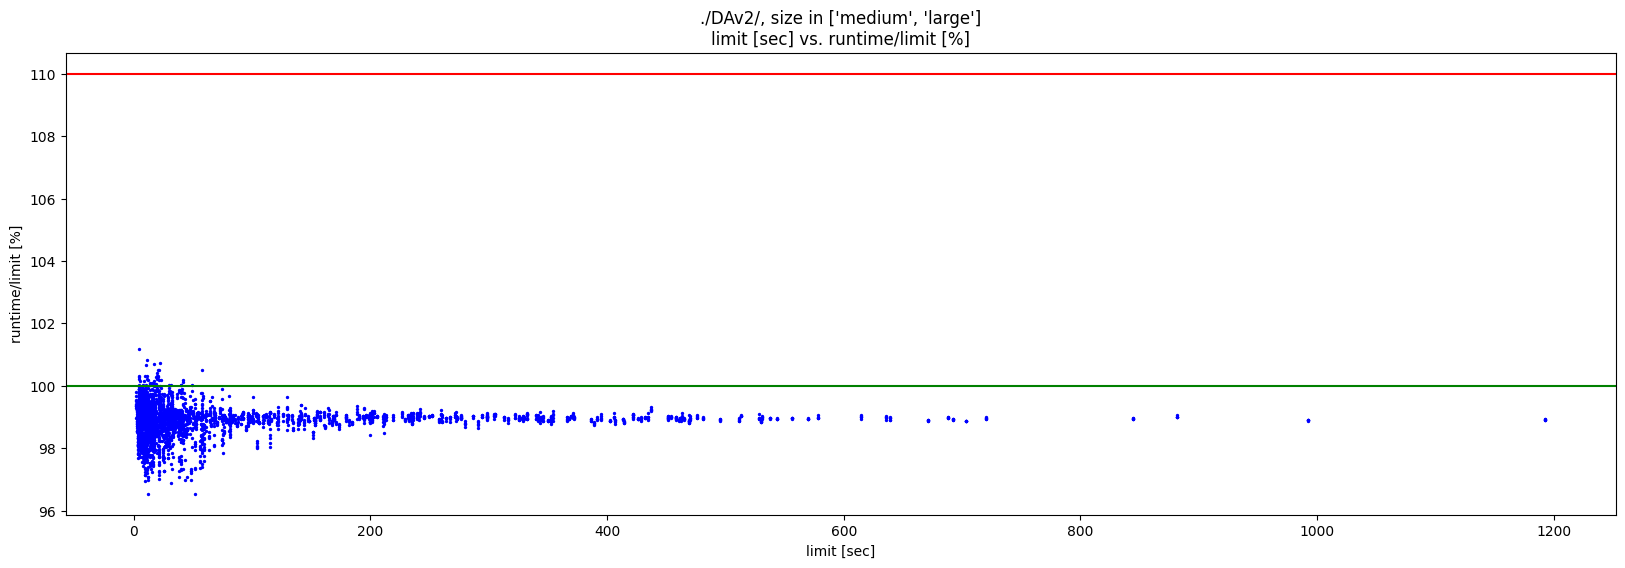

all:  runs 3690 cases 738.0
slow: runs 0 cases 0
+-----+--------+---------+--------+------------+---------------------+-----------------+---------------+
| #   | case   | nodes   | seed   | filename   | runtime/limit [%]   | runtime [sec]   | limit [sec]   |
|-----+--------+---------+--------+------------+---------------------+-----------------+---------------|
+-----+--------+---------+--------+------------+---------------------+-----------------+---------------+
+--------+-------+-------+---------------------+
| case   | len   | max   | runtime/limit [%]   |
|--------+-------+-------+---------------------|
+--------+-------+-------+---------------------+


In [16]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from IPython.display import display, HTML
from decimal import *
getcontext().prec = 50

df=pd.read_csv('baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

# ----------------------------------------------------------------------------
df = df[df['limit']>=0.25] # skip cases with limit below 250 msec
# ----------------------------------------------------------------------------

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_objectives = {}
all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})
for name, filename, seed, objective, runtime, solution in zip(all_df['name'], all_df['file'], all_df['seed'], all_df['objective'], all_df['runtime'], all_df['solution']):
    if os.path.isfile(filename):
        if filename not in all_objectives:
            all_objectives[filename] = {'file':filename, 'heuristic':os.path.basename(os.path.dirname(filename)), 'name':name, 'experiments':{}}
        all_objectives[filename]['experiments'][seed] = {'objective': objective, 'runtime': runtime, 'solution': solution}
    else:
        print(f'Cant\'t find {filename}!')

dirname = './DAv2/'
target_sizes =  ['medium', 'large']

X = []
Y = []
all_counter = 0
slow_runs = []
slow_cases = {}
header =  ('#', 'case', 'nodes', 'seed', 'filename', 'runtime/limit [%]', 'runtime [sec]', 'limit [sec]')
for name, limit, nodes, density_value in zip(df['name'], df['limit'], df['nodes'], df['density']):

    size = get_size(nodes)
    density = get_density(density_value)             
    
    if size in target_sizes:
        for filename in all_objectives:
            if filename.startswith(dirname) and (f'{name}-{limit:.3f}-5.csv' in filename):
                
                for seed in all_objectives[filename]['experiments']:
                    runtime = all_objectives[filename]['experiments'][seed]['runtime']
                    rate = 100*runtime/limit
                    X.append(limit)
                    Y.append(rate)
                    all_counter += 1
                    if rate > 110:
                        slow_runs.append((len(slow_runs)+1, name, nodes, seed, filename, rate, runtime, limit))
                        if name not in slow_cases:
                            slow_cases[name] = []
                        slow_cases[name].append(rate)

plt.close()
fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(X, Y, s=2, color='blue')
ax.set_title(f'{dirname}, size in {target_sizes}\nlimit [sec] vs. runtime/limit [%]')
ax.set_xlabel('limit [sec]')
ax.set_ylabel('runtime/limit [%]')
plt.axhline(y=110, color='red', linestyle='-')
plt.axhline(y=100, color='green', linestyle='-')
plt.show()

print('all: ', 'runs', all_counter, 'cases', all_counter / 5)
print('slow:', 'runs', len(slow_runs), 'cases', len(slow_cases))

print(tabulate.tabulate(slow_runs, header, floatfmt='.3f', tablefmt='psql'))
print(tabulate.tabulate([(case, len(rates), max(rates), rates) for case, rates in slow_cases.items()], ['case',  'len', 'max', 'runtime/limit [%]'], tablefmt='psql'))

In [11]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from IPython.display import display, HTML
from decimal import *
getcontext().prec = 50

df=pd.read_csv('baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

# ----------------------------------------------------------------------------
df = df[df['limit']>=0.25] # skip cases with limit below 250 msec
# ----------------------------------------------------------------------------

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_objectives = {}
all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})
for name, filename, seed, objective, runtime, solution in zip(all_df['name'], all_df['file'], all_df['seed'], all_df['objective'], all_df['runtime'], all_df['solution']):
    if os.path.isfile(filename):
        if filename not in all_objectives:
            all_objectives[filename] = {'file':filename, 'heuristic':os.path.basename(os.path.dirname(filename)), 'name':name, 'experiments':{}}
        all_objectives[filename]['experiments'][seed] = {'objective': objective, 'runtime': runtime, 'solution': solution}
    else:
        print(f'Cant\'t find {filename}!')

dirname = './DAv2/'
for target_sizes, target_densities, create_drilldown in [ 

        (['medium', 'large'], densities, True ), 

        #(['x-small'], densities, False ), 
        (['x-small'], ['sparse'], False ), 
        (['x-small'], ['medium'], False ), 
        (['x-small'], ['dense'], False ), 
    
        #(['small'], densities, False ), 
        (['small'], ['sparse'], False ), 
        (['small'], ['medium'], False ), 
        (['small'], ['dense'], False ), 

        #(['medium'], densities, False ), 
        (['medium'], ['sparse'], False ), 
        (['medium'], ['medium'], False ), 
        (['medium'], ['dense'], False ), 
        
        #(['large'], densities, False ), 
        (['large'], ['sparse'], False ), 
        (['large'], ['medium'], False ), 
        (['large'], ['dense'], False ), 
    ]:

    header =  ('#', 'case', 'nodes', 'objective', 'heuristic', 'objective_heuristic', 'rate', 'sign')
    table = []
    sign_counters = {'>':0, '=':0, '<':0, '?':0}
    rates = []
    i_rates = []
    f_rates = []
    for name, limit, nodes, density_value, int_only in zip(df['name'], df['limit'], df['nodes'], df['density'], df['int_only']):
    
        size = get_size(nodes)
        density = get_density(density_value)  
        heuristic = heuristic_map[density][size]
        
        if size in target_sizes:
            if density in target_densities:
                max_objective = None
                max_objective_heuristic = None
        
                for filename in all_objectives:
                    if filename.startswith(dirname) and (f'{name}-{limit:.3f}-5.csv' in filename):
        
                        for seed in all_objectives[filename]['experiments']:
                            objective = all_objectives[filename]['experiments'][seed]['objective']
                            if max_objective is None or objective>max_objective:
                                max_objective = objective
                        
                    if filename.startswith(f"./{heuristic}/") and (f'{name}-{limit:.3f}-5.csv' in filename):
                        
                        for seed in all_objectives[filename]['experiments']:
                            objective = all_objectives[filename]['experiments'][seed]['objective']
                            if max_objective_heuristic is None or objective>max_objective_heuristic:
                                max_objective_heuristic = objective
        
                rate = None
                if max_objective is not None and max_objective_heuristic is not None:
                    if max_objective == 0 and max_objective_heuristic == 0:
                        rate = Decimal(1.0)
                    else:
                        try:                    
                            rate = max_objective / max_objective_heuristic
                        except Exception as oops:
                            print(name, max_objective, max_objective_heuristic, oops)
                sign = '?' if rate is None else ( '=' if rate == 1 else ('<' if rate < 1 else '>'))
                sign_counters[sign] += 1
                rates.append(rate)     
                if int_only:
                    i_rates.append(rate)
                else:
                    f_rates.append(rate)
                    
                table.append((len(table)+1, name, nodes, max_objective, heuristic, max_objective_heuristic, rate, sign))

    if sign_counters['?'] == 0:
        del sign_counters['?']

    print(dirname, target_sizes, target_densities, sum(sign_counters.values()), sign_counters)
    print(dirname, target_sizes, target_densities, sum(sign_counters.values()), {sign:f"{100*counter/sum(sign_counters.values()):.1f}%" for sign, counter in sign_counters.items()})

    #print(tabulate.tabulate(table, header, floatfmt='.3f', tablefmt='psql'))

    if create_drilldown:
        step = Decimal(0.002)

        drilldown = []
        
        upper = Decimal(1.0) + Decimal(-6)*step
        drilldown.append((f'[  inf - {upper:.3f})', 
              len([rate for rate in rates if rate < upper]), 
              len([rate for rate in i_rates if rate < upper]),
              len([rate for rate in f_rates if rate < upper])))
    
        for i in range(-6, 0, +1):
            lower = Decimal(1.0) + Decimal(i)*step
            upper = Decimal(1.0) + Decimal(i+1)*step
            drilldown.append((f'[{lower:.3f} - {upper:.3f})', 
                  len([rate for rate in rates if lower <= rate < upper]), 
                  len([rate for rate in i_rates if lower <= rate < upper]), 
                  len([rate for rate in f_rates if lower <= rate < upper])))
            
        drilldown.append(('      1.0      ', 
              len([rate for rate in rates if rate == 1.0]), 
              len([rate for rate in i_rates if rate == 1.0]), 
              len([rate for rate in f_rates if rate == 1.0])))
    
        for i in range(7):
            lower = Decimal(1.0) + Decimal(i)*step
            upper = Decimal(1.0) + Decimal(i+1)*step
            drilldown.append((f'({lower:.3f} - {upper:.3f}]', 
                  len([rate for rate in rates if lower < rate <= upper]), 
                  len([rate for rate in i_rates if lower < rate <= upper]),
                  len([rate for rate in f_rates if lower < rate <= upper])))
    
        lower = Decimal(1.0) + Decimal(7)*step
        drilldown.append((f'({lower:.3f} - inf  ]', 
              len([rate for rate in rates if lower < rate]),
              len([rate for rate in i_rates if lower < rate]), 
              len([rate for rate in f_rates if lower < rate])))
        
        print(tabulate.tabulate(drilldown, ('range', 'all', 'int', 'float'), floatfmt='.3f', tablefmt='psql'))

    print()

./DAv2/ ['medium', 'large'] ['sparse', 'medium', 'dense'] 738 {'>': 511, '=': 88, '<': 139}
./DAv2/ ['medium', 'large'] ['sparse', 'medium', 'dense'] 738 {'>': '69.2%', '=': '11.9%', '<': '18.8%'}
+-----------------+-------+-------+---------+
| range           |   all |   int |   float |
|-----------------+-------+-------+---------|
| [  inf - 0.988) |     2 |     0 |       2 |
| [0.988 - 0.990) |     1 |     0 |       1 |
| [0.990 - 0.992) |     0 |     0 |       0 |
| [0.992 - 0.994) |     2 |     0 |       2 |
| [0.994 - 0.996) |     8 |     0 |       8 |
| [0.996 - 0.998) |    16 |     1 |      15 |
| [0.998 - 1.000) |   110 |    44 |      66 |
| 1.0             |    88 |    59 |      29 |
| (1.000 - 1.002] |   247 |    75 |     172 |
| (1.002 - 1.004] |    98 |    59 |      39 |
| (1.004 - 1.006] |    55 |    32 |      23 |
| (1.006 - 1.008] |    30 |    23 |       7 |
| (1.008 - 1.010] |    21 |    16 |       5 |
| (1.010 - 1.012] |    20 |    12 |       8 |
| (1.012 - 1.014] |  

# DAv3

In [8]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from IPython.display import display, HTML
from decimal import *
getcontext().prec = 50

df=pd.read_csv('baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

# ----------------------------------------------------------------------------
df = df[df['limit']>=0.25] # skip cases with limit below 250 msec
# ----------------------------------------------------------------------------

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_objectives = {}
all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})
for name, filename, seed, objective, runtime, solution in zip(all_df['name'], all_df['file'], all_df['seed'], all_df['objective'], all_df['runtime'], all_df['solution']):
    if os.path.isfile(filename):
        if filename not in all_objectives:
            all_objectives[filename] = {'file':filename, 'heuristic':os.path.basename(os.path.dirname(filename)), 'name':name, 'experiments':{}}
        all_objectives[filename]['experiments'][seed] = {'objective': objective, 'runtime': runtime, 'solution': solution}
    else:
        print(f'Cant\'t find {filename}!')

dirname = './DAv3/'

for OFFSET in range(6):

    for target_sizes in [ ['medium', 'large', 'x-large']]: # , ['medium'], ['large'], ['x-large']
    
        X = []
        Y = []
        all_counter = 0
        slow_runs = []
        slow_cases = {}
        header =  ('#', 'case', 'nodes', 'seed', 'filename', 'runtime/limit [%]', 'runtime [sec]', 'limit [sec]', 'time_limit_sec')
        for name, limit, nodes, density_value in zip(df['name'], df['limit'], df['nodes'], df['density']):
        
            size = get_size(nodes)
            density = get_density(density_value)  
            time_limit_sec = calc_time_limit_sec(limit, OFFSET)
            
            if size in target_sizes:
                for filename in all_objectives:
                    if filename.startswith(dirname) and (f'{name}-{time_limit_sec:d}-5.csv' in filename):
    
                        for seed in all_objectives[filename]['experiments']:
                            runtime = all_objectives[filename]['experiments'][seed]['runtime']
                            rate = 100*runtime/limit
                            X.append(limit)
                            Y.append(rate)
                            all_counter += 1
                            if rate > 110:
                                slow_runs.append((len(slow_runs)+1, name, nodes, seed, filename, rate, runtime, limit, time_limit_sec))
                                if name not in slow_cases:
                                    slow_cases[name] = []
                                slow_cases[name].append(rate)

        if False:
            plt.close()
            fig, ax = plt.subplots(figsize=(20,6))
            ax.scatter(X, Y, s=2, color='blue')
            ax.set_title(f'{dirname}, size in {target_sizes}\nlimit [sec] vs. runtime/limit [%]\noffset={OFFSET}')
            ax.set_xlabel('limit [sec]')
            ax.set_ylabel('runtime/limit [%]')
            plt.axhline(y=110, color='red', linestyle='-')
            plt.axhline(y=100, color='green', linestyle='-')
            plt.show()
        
        print(f'[offset={OFFSET}]', 'all: ', 'runs', all_counter, 'cases', all_counter / 5)
        print(f'[offset={OFFSET}]', 'slow:', 'runs', len(slow_runs), 'cases', len(slow_cases), 'mean runs/case', len(slow_runs)/len(slow_cases))
    
        #print(tabulate.tabulate(slow_runs, header, floatfmt='.3f', tablefmt='psql'))
        #print(tabulate.tabulate([(case, len(rates), max(rates), rates) for case, rates in slow_cases.items()], ['case',  'len', 'max', 'runtime/limit [%]'], tablefmt='psql'))
        
        print()

print('\nready')

[offset=0] all:  runs 4095 cases 819.0
[offset=0] slow: runs 837 cases 203 mean runs/case 4.123152709359606

[offset=1] all:  runs 4095 cases 819.0
[offset=1] slow: runs 639 cases 163 mean runs/case 3.920245398773006

[offset=2] all:  runs 4095 cases 819.0
[offset=2] slow: runs 277 cases 81 mean runs/case 3.419753086419753

[offset=3] all:  runs 4095 cases 819.0
[offset=3] slow: runs 38 cases 15 mean runs/case 2.533333333333333

[offset=4] all:  runs 4095 cases 819.0
[offset=4] slow: runs 20 cases 5 mean runs/case 4.0

[offset=5] all:  runs 4095 cases 819.0
[offset=5] slow: runs 20 cases 5 mean runs/case 4.0


ready


In [10]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from IPython.display import display, HTML
from decimal import *
getcontext().prec = 50

df=pd.read_csv('baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

# ----------------------------------------------------------------------------
df = df[df['limit']>=0.25] # skip cases with limit below 250 msec
# ----------------------------------------------------------------------------

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_objectives = {}
all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})
for name, filename, seed, objective, runtime, solution in zip(all_df['name'], all_df['file'], all_df['seed'], all_df['objective'], all_df['runtime'], all_df['solution']):
    if os.path.isfile(filename):
        if filename not in all_objectives:
            all_objectives[filename] = {'file':filename, 'heuristic':os.path.basename(os.path.dirname(filename)), 'name':name, 'experiments':{}}
        all_objectives[filename]['experiments'][seed] = {'objective': objective, 'runtime': runtime, 'solution': solution}
    else:
        print(f'Cant\'t find {filename}!')

dirname = './DAv3/'

for OFFSET in [3, 4]:

    for target_sizes, target_densities, create_drilldown in [ 
            (['medium', 'large', 'x-large'], densities, True ), 
        
            #(['medium'], densities ), 
            (['medium'], ['sparse'], False ), 
            (['medium'], ['medium'], False ), 
            (['medium'], ['dense'], False ), 
            
            #(['large'], densities ), 
            (['large'], ['sparse'], False ), 
            (['large'], ['medium'], False ), 
            (['large'], ['dense'], False ), 
            
            #(['x-large'], densities, False ), 
            (['x-large'], ['sparse'], False ), 
        ]:
    
        header =  ('#', 'case', 'nodes', 'objective', 'heuristic', 'objective_heuristic', 'rate', 'sign')
        table = []
        sign_counters = {'>':0, '=':0, '<':0, '?':0}
        rates = []
        i_rates = []
        f_rates = []
        for name, limit, nodes, density_value, int_only in zip(df['name'], df['limit'], df['nodes'], df['density'], df['int_only']):
        
            size = get_size(nodes)
            density = get_density(density_value)  
            time_limit_sec = calc_time_limit_sec(limit, OFFSET)
            heuristic = heuristic_map[density][size]
            
            if size in target_sizes:
                if density in target_densities:
                    max_objective = None
                    max_objective_heuristic = None
            
                    for filename in all_objectives:
                        if filename.startswith(dirname) and (f'{name}-{time_limit_sec:d}-5.csv' in filename):
            
                            for seed in all_objectives[filename]['experiments']:
                                objective = all_objectives[filename]['experiments'][seed]['objective']
                                if max_objective is None or objective>max_objective:
                                    max_objective = objective
                            
                        if filename.startswith(f"./{heuristic}/") and (f'{name}-{limit:.3f}-5.csv' in filename):
                            
                            for seed in all_objectives[filename]['experiments']:
                                objective = all_objectives[filename]['experiments'][seed]['objective']
                                if max_objective_heuristic is None or objective>max_objective_heuristic:
                                    max_objective_heuristic = objective
    
                    rate = None
                    if max_objective is not None and max_objective_heuristic is not None:
                        if max_objective == 0 and max_objective_heuristic == 0:
                            rate = 1.0
                        else:
                            try:                    
                                rate = max_objective / max_objective_heuristic
                            except Exception as oops:
                                print(name, max_objective, max_objective_heuristic, oops)
                    sign = '?' if rate is None else ( '=' if rate == 1 else ('<' if rate < 1 else '>'))
                    sign_counters[sign] += 1
                    rates.append(rate)      
                    if int_only:
                        i_rates.append(rate)
                    else:
                        f_rates.append(rate)
                        
                    table.append((len(table)+1, name, nodes, max_objective, heuristic, max_objective_heuristic, rate, sign))

        if sign_counters['?'] == 0:
            del sign_counters['?']
    
        print(f'[offset={OFFSET}]', dirname, target_sizes, target_densities, sum(sign_counters.values()), sign_counters)
        print(f'[offset={OFFSET}]', dirname, target_sizes, target_densities, sum(sign_counters.values()), {sign:f"{100*counter/sum(sign_counters.values()):.1f}%" for sign, counter in sign_counters.items()})
        
        #print(tabulate.tabulate(table, header, floatfmt='.3f', tablefmt='psql'))

        if create_drilldown:
            step = Decimal(0.002)
    
            drilldown = []
            
            upper = Decimal(1.0) + Decimal(-6)*step
            drilldown.append((f'[  inf - {upper:.3f})', 
                  len([rate for rate in rates if rate < upper]), 
                  len([rate for rate in i_rates if rate < upper]),
                  len([rate for rate in f_rates if rate < upper])))
        
            for i in range(-6, 0, +1):
                lower = Decimal(1.0) + Decimal(i)*step
                upper = Decimal(1.0) + Decimal(i+1)*step
                drilldown.append((f'[{lower:.3f} - {upper:.3f})', 
                      len([rate for rate in rates if lower <= rate < upper]), 
                      len([rate for rate in i_rates if lower <= rate < upper]), 
                      len([rate for rate in f_rates if lower <= rate < upper])))
                
            drilldown.append(('      1.0      ', 
                  len([rate for rate in rates if rate == 1.0]), 
                  len([rate for rate in i_rates if rate == 1.0]), 
                  len([rate for rate in f_rates if rate == 1.0])))
        
            for i in range(7):
                lower = Decimal(1.0) + Decimal(i)*step
                upper = Decimal(1.0) + Decimal(i+1)*step
                drilldown.append((f'({lower:.3f} - {upper:.3f}]', 
                      len([rate for rate in rates if lower < rate <= upper]), 
                      len([rate for rate in i_rates if lower < rate <= upper]),
                      len([rate for rate in f_rates if lower < rate <= upper])))
        
            lower = Decimal(1.0) + Decimal(7)*step
            drilldown.append((f'({lower:.3f} - inf  ]', 
                  len([rate for rate in rates if lower < rate]),
                  len([rate for rate in i_rates if lower < rate]), 
                  len([rate for rate in f_rates if lower < rate])))
            
            print(tabulate.tabulate(drilldown, ('range', 'all', 'int', 'float'), floatfmt='.3f', tablefmt='psql'))
    
        print()

print('\nready')

[offset=3] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium', 'dense'] 819 {'>': 498, '=': 142, '<': 179}
[offset=3] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium', 'dense'] 819 {'>': '60.8%', '=': '17.3%', '<': '21.9%'}
+-----------------+-------+-------+---------+
| range           |   all |   int |   float |
|-----------------+-------+-------+---------|
| [  inf - 0.988) |    10 |     8 |       2 |
| [0.988 - 0.990) |     8 |     7 |       1 |
| [0.990 - 0.992) |     6 |     6 |       0 |
| [0.992 - 0.994) |     7 |     4 |       3 |
| [0.994 - 0.996) |    12 |     4 |       8 |
| [0.996 - 0.998) |    25 |     2 |      23 |
| [0.998 - 1.000) |   111 |     1 |     110 |
| 1.0             |   142 |    84 |      58 |
| (1.000 - 1.002] |   223 |   100 |     123 |
| (1.002 - 1.004] |    82 |    47 |      35 |
| (1.004 - 1.006] |    42 |    22 |      20 |
| (1.006 - 1.008] |    37 |    14 |      23 |
| (1.008 - 1.010] |    40 |    26 |      14 |
| (1.010 - 1.012] |   

In [9]:
import os
import math
import glob
import tabulate
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from datetime import timedelta
from datetime import datetime
from IPython.display import display, HTML
from decimal import *
getcontext().prec = 50

df=pd.read_csv('baseline.csv')
df = df[df['nodes']>20]# skip tiny cases with 20 or less nodes, like the original MQLIB paper did
df = df.sort_values(by='limit')

# ----------------------------------------------------------------------------
df = df[df['limit']>=0.25] # skip cases with limit below 250 msec
df = df[df['nodes']>=2048] # skip cases with nodes below 2048
# ----------------------------------------------------------------------------

def decimal_from_value(value):
    return Decimal(value)

def str_from_value(value):
    return str(value)

all_objectives = {}
all_df=pd.read_csv('all.csv', converters={'objective':decimal_from_value, 'solution':str_from_value})
for name, filename, seed, objective, runtime, solution in zip(all_df['name'], all_df['file'], all_df['seed'], all_df['objective'], all_df['runtime'], all_df['solution']):
    if os.path.isfile(filename):
        if filename not in all_objectives:
            all_objectives[filename] = {'file':filename, 'heuristic':os.path.basename(os.path.dirname(filename)), 'name':name, 'experiments':{}}
        all_objectives[filename]['experiments'][seed] = {'objective': objective, 'runtime': runtime, 'solution': solution}
    else:
        print(f'Cant\'t find {filename}!')

dirname = './DAv3/'

for OFFSET in range(6):

    for target_sizes, target_densities in [ 
            (['medium', 'large', 'x-large'], densities ), 
        ]:
    
        header =  ('#', 'case', 'nodes', 'objective', 'heuristic', 'objective_heuristic', 'rate', 'sign')
        table = []
        sign_counters = {'>':0, '=':0, '<':0, '?':0}
        rates = []
        for name, limit, nodes, density_value in zip(df['name'], df['limit'], df['nodes'], df['density']):
        
            size = get_size(nodes)
            density = get_density(density_value)  
            time_limit_sec = calc_time_limit_sec(limit, OFFSET)
            heuristic = heuristic_map[density][size]
            
            if size in target_sizes:
                if density in target_densities:
                    max_objective = None
                    max_objective_heuristic = None
            
                    for filename in all_objectives:
                        if filename.startswith(dirname) and (f'{name}-{time_limit_sec:d}-5.csv' in filename):
            
                            for seed in all_objectives[filename]['experiments']:
                                objective = all_objectives[filename]['experiments'][seed]['objective']
                                if max_objective is None or objective>max_objective:
                                    max_objective = objective
                            
                        if filename.startswith(f"./{heuristic}/") and (f'{name}-{limit:.3f}-5.csv' in filename):
                            
                            for seed in all_objectives[filename]['experiments']:
                                objective = all_objectives[filename]['experiments'][seed]['objective']
                                if max_objective_heuristic is None or objective>max_objective_heuristic:
                                    max_objective_heuristic = objective
    
                    rate = None
                    if max_objective is not None and max_objective_heuristic is not None:
                        if max_objective == 0 and max_objective_heuristic == 0:
                            rate = Decimal(1.0)
                        else:
                            try:                    
                                rate = max_objective / max(max_objective, max_objective_heuristic)
                            except Exception as oops:
                                print(name, max_objective, max_objective_heuristic, oops)
                    sign = '?' if rate is None else ( '=' if rate == 1 else ('<' if rate < 1 else '>'))
                    sign_counters[sign] += 1
                    rates.append(rate)
                        
                    #print(name, max_objective, type(max_objective), max_objective_heuristic, type(max_objective_heuristic), rate, type(rate), f'"{sign}"')
                    
                    table.append((len(table)+1, name, nodes, max_objective, heuristic, max_objective_heuristic, rate, sign))
            
    
        print(f'[offset={OFFSET}]', dirname, target_sizes, target_densities, sum(sign_counters.values()), sign_counters, 'mean(rate)', sum(rates)/Decimal(len(rates)))
        
        #print(tabulate.tabulate(table, header, floatfmt='.3f', tablefmt='psql'))

        print()

print('\nready')

[offset=0] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium', 'dense'] 819 {'>': 0, '=': 649, '<': 170, '?': 0} mean(rate) 0.99944738320155898781694079349599727447047627166392

[offset=1] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium', 'dense'] 819 {'>': 0, '=': 648, '<': 171, '?': 0} mean(rate) 0.99943115582607275363892950082337933182309257336451

[offset=2] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium', 'dense'] 819 {'>': 0, '=': 643, '<': 176, '?': 0} mean(rate) 0.99938743667589794851713216369059362261455267362630

[offset=3] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium', 'dense'] 819 {'>': 0, '=': 640, '<': 179, '?': 0} mean(rate) 0.99935344972742284057437904362302842804427143052635

[offset=4] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium', 'dense'] 819 {'>': 0, '=': 636, '<': 183, '?': 0} mean(rate) 0.99926780891202645035021484094496949620813714368116

[offset=5] ./DAv3/ ['medium', 'large', 'x-large'] ['sparse', 'medium',